In [1]:
import numpy as np
import matplotlib.pyplot as plt
import maxflow
from math import sqrt

import pandas

In [2]:
from diffpy.structure import Atom, Lattice, Structure
from orix import plot
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.io import load, save
from orix.quaternion import Orientation, Rotation, symmetry, Misorientation
from orix.vector import Vector3d

In [3]:
from loadAng import loadAng, getLibraryPhaseList
from full_from_diag import full_from_diag

In [4]:
dataPath = 'data/'
# fileName = 'ferrite.ang' ### hexgrid
fileName = 'steel_ebsd.ang' ### squaregrid
target = dataPath + fileName
MaterialName = 'Ferrite'

In [5]:
# xmap = load(dataPath + fileName) ### currently does not handle 

GRID, NCOLS_ODD, NCOLS_EVEN, NROWS, numEBSDColumns = loadAng(target)
NCOLS_ODD = int(NCOLS_ODD)
NCOLS_EVEN = int(NCOLS_EVEN)
NROWS = int(NROWS)
numEBSDColumns = int(numEBSDColumns)

print(GRID, NCOLS_ODD, NCOLS_EVEN, NROWS, numEBSDColumns)

if numEBSDColumns == 10:
    euler1, euler2, euler3, x, y, iq, ci, phase_id, sem, fit = np.loadtxt(target, unpack=True)
else:
    print('TODO handle more/fewer columns')

euler_angles = np.column_stack((euler1, euler2, euler3))
rotations = Rotation.from_euler(euler_angles)
properties = dict(iq=iq, dp=ci)

print(euler_angles.shape)

phase_list = getLibraryPhaseList('Ferrite')

# Create a CrystalMap instance
xmap2 = CrystalMap(
    rotations=rotations,
    phase_id=phase_id,
    x=x,
    y=y,
    phase_list=phase_list,
    prop=properties,
)
xmap2.scan_unit = "um"

print(xmap2)

ckey_m3m = plot.IPFColorKeyTSL(xmap2.phases["ferrite"].point_group, direction=Vector3d.zvector())
rgb_fe = ckey_m3m.orientation2color(xmap2["ferrite"].orientations)

0 # TEM_PIXperUM          1.000000

1 # x-star                0.000000

2 # y-star                0.000000

3 # z-star                0.000000

4 # WorkingDistance       0.000000

5 #

6 # Phase 0

7 # MaterialName  	Ferrite

8 # Formula     	

9 # Info 		

10 # Symmetry              129

11 # LatticeConstants       2.870 2.870 2.870  90.000  90.000  90.000

12 # NumberFamilies        0

13 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

14 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

15 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

16 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

17 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

18 # ElasticConstants 	0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

19 # Categories0 0 0 0 0 

20 #

21 # GRID: SqrGrid

22 # XSTEP: 0.500000

23 # YSTEP: 0.500000

24 # NCOLS_ODD: 305

25 # NCOLS_EVEN: 305

2

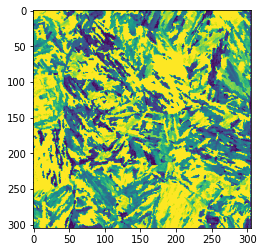

In [6]:
################################
### start building structure to feed into network
### build square array of hex grid points for graph cut
### populate pixels with R channel of orientation image
### leave non-indexed or other phases as zeros

if GRID == 'HexGrid':

    nodeDataArr = np.zeros((NROWS, NCOLS_ODD))

    cRow = 0
    cID = 0

    for pair in np.arange(int(NROWS/2)):

        nodeDataArr[cRow, :NCOLS_EVEN] = rgb_fe[cID:cID+NCOLS_EVEN][:,0] ### even
        cRow += 1
        cID = cID+NCOLS_EVEN

        nodeDataArr[cRow, :NCOLS_ODD] = rgb_fe[cID:cID+NCOLS_ODD][:,0] ### odd
        cRow += 1
        cID = cID+NCOLS_ODD

        # print(cRow, pair)

    plt.imshow(nodeDataArr)
    axes=plt.gca()
    axes.set_aspect(0.5)
    plt.show()

elif GRID == 'SqrGrid':
    ### squaregrid data for graphcut

    nodeData2 = np.zeros((xmap2.id.shape[0], 1))
    ferriteIDs =  xmap2['ferrite'].id
    ferriteGray = rgb_fe[:,0]
    failCounter = 0

    for i in xmap2.id:
        # print(i)
        try:
            # print(i)
            idx = np.where(ferriteIDs == i)[0][0]
            nodeData2[i] = ferriteGray[idx]
        except:
            # print('no value', failCounter)
            failCounter += 1

    n = np.round(sqrt(xmap2.id.shape[0])).astype(int)
    nodeDataArr = np.reshape(nodeData2, (n,n))

    plt.imshow(nodeDataArr)
    plt.show()

In [7]:
### start graphcut

ip_weight = 0.01 ### max > ip_weight > min of data as a place to start

g = maxflow.GraphFloat()
if GRID == 'HexGrid':
    nodeids = g.add_grid_nodes((NROWS, NCOLS_ODD))
    structure = np.array([[0, 1, 1],
                      [1, 0, 1],
                      [0, 1, 1]]) ### struct for hex grid
elif GRID == 'SqrGrid':
    nodeids = g.add_grid_nodes((n,n))
    # structure = maxflow.vonNeumann_structure(ndim=2, directed=True) ### square grid structure
    structure = np.array([[0, 1, 0],
                          [1, 0, 1],
                          [0, 1, 0]]) ### struct for square grid
    
g.add_grid_edges(nodeids, ip_weight, structure=structure)
g.add_grid_tedges(nodeids, nodeDataArr, 1-nodeDataArr)

# g.maxflow()

# sgm = g.get_grid_segments(nodeids)
# print(np.sum(sgm))
# img2 = np.int_(np.logical_not(sgm))

# plt.imshow(img2)
# if GRID == 'HexGrid':
#     axes=plt.gca()
#     axes.set_aspect(0.5)
# plt.show()

In [8]:
import networkx as nx
import scipy.sparse as sp
C = g.get_nx_graph()

AA = nx.to_scipy_sparse_array(C)
sparseUpperArr = sp.triu(AA)

u,v,wt = sp.find(sparseUpperArr)
connectivity = np.asanyarray([u,v])

#%%
sink = np.amax(connectivity.ravel())
source = sink-1
source_edges = np.any(connectivity==source,axis=0)
sink_edges = np.any(connectivity==sink, axis=0)
out_plane_loc = np.any(np.vstack([source_edges, sink_edges]), axis=0)
connectivity2 = connectivity[:, ~out_plane_loc]

#%%
o1 = xmap2.rotations[connectivity2[0,:]]
o2 = xmap2.rotations[connectivity2[1,:]]

m = Misorientation([o1.data, o2.data])
m.symmetry = (symmetry.Oh, symmetry.Oh)
m2 = m.map_into_symmetry_reduced_zone()
D2 = m2.angle

In [9]:
#%% Update graph with new in-plane weights

# This method preserves the out of plane weights already assigned, reassigning the in-plane weights
CC = sp.csr_array(AA)
CC[connectivity2[0,:],connectivity2[1,:]] = D2[0,:]
sparseUpperArr = sp.triu(CC)
CCC = full_from_diag(sparseUpperArr)
print(CCC)

# Return sparse matrix to networkx format
# newC = nx.from_scipy_sparse_array(CC)

[[1.00000000e+00 0.00000000e+00 4.96556154e-01]
 [3.05000000e+02 0.00000000e+00 4.96556154e-01]
 [0.00000000e+00 1.00000000e+00 4.96556154e-01]
 ...
 [9.30220000e+04 9.30260000e+04 6.83862760e-01]
 [9.30230000e+04 9.30260000e+04 3.56444304e-01]
 [9.30240000e+04 9.30260000e+04 1.00000000e+00]]


In [10]:
print(CCC.shape)

(437468, 3)


In [11]:
print(np.amax(CCC))

sinkID = int(np.amax(CCC))
sourceID = sinkID - 1

print(CCC[0])

93026.0
[1.         0.         0.49655615]


In [12]:
print(np.amax(CCC, where=True))

93026.0


In [13]:
sinkID in CCC[0]

False

In [14]:
sinkID = int(np.amax(CCC))
sourceID = sinkID - 1
# ip_weight = 0.01 ### max > ip_weight > min of data as a place to start
g2 = maxflow.GraphFloat()
nodeids = g2.add_grid_nodes((NROWS, NCOLS_ODD))
sinkCount = 0
sourceCount = 0
edgeCount = 0

normIq = iq / np.amax(iq)
nodeDataFlat = nodeDataArr.flatten()

for i in np.arange(CCC.shape[0]):
    cEdge = CCC[i]

    if sinkID in cEdge:
        # cNode = int(np.min((cEdge[0], cEdge[1])))
        # g2.add_tedge(cNode, nodeDataFlat[cNode], nodeDataFlat[cNode]-1)
        # # g2.add_tedge(cNode, normIq[cNode], 1/normIq[cNode])
        # # g2.add_tedge(cNode, ferriteGray[cNode], ferriteGray[cNode]-1)
        # # # print('sink', sinkCount)
        # sinkCount +=1
        pass
    elif sourceID in cEdge:
        # cNode = int(np.min((cEdge[0], cEdge[1])))
        # g2.add_tedge(cNode, nodeDataFlat[cNode], nodeDataFlat[cNode]-1)
        # # cNode = int(np.min((cEdge[0], cEdge[1])))
        # # # g2.add_tedge(cNode, nodeDataArr, nodeDataArr-1)
        # # g2.add_tedge(cNode, normIq[cNode], 1/normIq[cNode])
        # # # g2.add_edge(cEdge[0], cEdge[1], 1)
        # # # print('source', sourceCount)
        # sourceCount +=1
        pass
    else:
        g2.add_edge(int(cEdge[0]), int(cEdge[1]), cEdge[2], cEdge[2])
        # print('edge', edgeCount)
        edgeCount +=1
    
g2.add_grid_tedges(nodeids, nodeDataArr, 1-nodeDataArr)



In [15]:
print(CCC.shape[0])
print(edgeCount+sinkCount) #+sourceCount)

437468
370174


15831


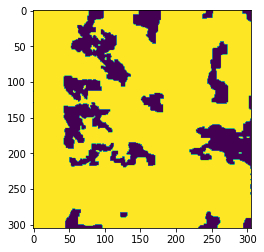

[0 1]


In [16]:
g2.maxflow()

sgm = g2.get_grid_segments(nodeids)
print(np.sum(sgm))
img2 = np.int_(np.logical_not(sgm))

plt.imshow(img2)
if GRID == 'HexGrid':
    axes=plt.gca()
    axes.set_aspect(0.5)
plt.show()

print(np.unique(img2))

In [17]:
print('sink', sinkCount)
print('source', sourceCount)
print('edge', edgeCount)

sink 0
source 0
edge 370174


In [18]:
denseWeights = CCC.todense()
print(denseWeights.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

In [ ]:
### start graphcut

ip_weight = 0.01 ### max > ip_weight > min of data as a place to start

g = maxflow.GraphFloat()
if GRID == 'HexGrid':
    nodeids = g.add_grid_nodes((NROWS, NCOLS_ODD))
    structure = np.array([[0, 1, 1],
                      [1, 0, 1],
                      [0, 1, 1]]) ### struct for hex grid
elif GRID == 'SqrGrid':
    nodeids = g.add_grid_nodes((n,n))
    # structure = maxflow.vonNeumann_structure(ndim=2, directed=True) ### square grid structure
    structure = np.array([[0, 1, 0],
                          [1, 0, 1],
                          [0, 1, 0]]) ### struct for square grid
    
g.add_grid_edges(nodeids, ip_weight, structure=structure)
g.add_grid_tedges(nodeids, nodeDataArr, 1-nodeDataArr)

# g.maxflow()

# sgm = g.get_grid_segments(nodeids)
# print(np.sum(sgm))
# img2 = np.int_(np.logical_not(sgm))

# plt.imshow(img2)
# if GRID == 'HexGrid':
#     axes=plt.gca()
#     axes.set_aspect(0.5)
# plt.show()

In [22]:
o1 = xmap2.rotations[connectivity2[0,:]] # orientation of node u
# o2 = xmap2.rotations[connectivity2[1,:]] # orientation of node v
m = Misorientation(o1*o1[100].conj).to_euler() # misorientations between every u and v

In [23]:
print(m)

[[4.86146539 0.70542801 4.80898908]
 [0.12284045 2.43276347 4.3216098 ]
 [5.18716659 1.33475471 5.32779988]
 ...
 [1.33912021 1.4503991  5.60330203]
 [0.51293265 1.16424    0.85860265]
 [2.85698929 2.32932715 2.95167676]]


In [10]:
from orix.io import load
from orix.quaternion import Rotation
from scipy.spatial.transform import Rotation as R

import numpy as np
# load up a thingie
# ebsd = load("AF_001.ang")
# just a tiny example of getting misorientation angles
ebsd = xmap2
sp_R = R.from_euler('ZXZ', ebsd.rotations.to_euler())
o1 = sp_R[:-1:2]
o2 = sp_R[1::2]
# this line gets the misorientation (but NOT wiht symmetry considerations,
# got to code that part up still)
mis = R.__mul__(o1, o2.inv())
# Now we just need to shave some lines off the tops and bottoms and flatten arrays
# to get left-right, up-down, and hex-corner pairs
ori_l = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[1:,:].flatten().to_euler())
ori_r = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[:-1,:].flatten().to_euler())
ori_u = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[:,1:].flatten().to_euler())
ori_d = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[:,:-1].flatten().to_euler())
ori_hex = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[1:,1:].flatten().to_euler())
ori_hex_2 = R.from_euler('ZXZ', ebsd.rotations.reshape(n, n)[:-1,:-1].flatten().to_euler())
# misorientation connections
lr_mis = R.__mul__(ori_l, ori_r.inv()).magnitude().reshape(n-1, n)
ud_mis = R.__mul__(ori_u, ori_d.inv()).magnitude().reshape(n, n-1)
hex_mis = R.__mul__(ori_hex, ori_hex_2.inv()).magnitude().reshape(n-1, n-1)

In [26]:
print(hex_mis.shape)

(304, 304)


In [31]:
print(lr_mis[0])

[2.67300858e+00 2.59640406e+00 2.59640406e+00 2.58356649e+00
 3.13264865e+00 0.00000000e+00 2.27082694e+00 4.57384946e-03
 2.10843915e+00 2.11526006e+00 2.75379089e+00 2.75379089e+00
 1.71512483e+00 2.05356565e+00 8.32667268e-17 2.24341741e-02
 1.38110649e-02 1.30826728e-02 2.45009868e+00 1.20507952e+00
 1.20507952e+00 2.62023155e+00 2.06002366e+00 0.00000000e+00
 3.11126338e+00 3.80998147e-02 1.37992891e+00 2.74789086e+00
 1.00864880e+00 1.00864880e+00 2.28885718e+00 2.16538005e-02
 0.00000000e+00 3.13397581e+00 3.13679530e+00 1.55278893e+00
 1.93786490e+00 2.30240588e+00 2.30240588e+00 2.31552622e+00
 5.37146958e-02 0.00000000e+00 2.80825165e-02 2.48334323e-02
 1.56187100e+00 3.13460990e+00 3.13323019e+00 2.28423497e+00
 2.45947817e+00 3.11980696e+00 1.38777878e-17 1.95888215e-01
 2.63864487e-02 5.10737232e-02 1.21746156e-02 4.88741339e-02
 2.46851426e+00 2.47487428e+00 2.53477235e+00 0.00000000e+00
 3.13110848e+00 0.00000000e+00 3.12197000e+00 2.65697656e-02
 1.29129896e+00 2.938485

In [11]:
import networkx as nx
import scipy.sparse as sp

In [12]:
C = g.get_nx_graph()
sparseArr = nx.to_scipy_sparse_array(C)
sparseUpperArr = sp.triu(sparseArr)


In [13]:
adjArr = sp.csr_matrix.todense(sparseUpperArr)
print(adjArr.shape)


(93027, 93027)


In [14]:
print(nodeids.shape)

(305, 305)


In [15]:
u, v, wt = sp.find(sparseArr)
connectArr = np.asanyarray([u,v])
print(connectArr.shape)

(2, 463905)


In [16]:
np.sum(connectArr.ravel()==93026)

33647

In [17]:
sumArr = np.zeros(93027)

for i in np.arange(93027):
    sumArr[i] = np.sum(connectArr.ravel()==i)

In [18]:
print(np.unique(sumArr))

[5.0000e+00 7.0000e+00 9.0000e+00 3.3647e+04 5.9378e+04]


In [19]:
idx = 3
print(np.where(sumArr == np.unique(sumArr)[idx])[0].shape)
print(np.where(sumArr == np.unique(sumArr)[idx]))

(1,)
(array([93026]),)


In [20]:
o1 = xmap2.rotations[connectArr[:,0]]
o2 = xmap2.rotations[connectArr[:,1]]
m = (~o1).outer(o2)

In [21]:
print(m)

Rotation (2, 2)
[[[ 0.1696  0.5941  0.1438 -0.7731]
  [-0.4519 -0.4678  0.2757 -0.7077]]

 [[ 0.2322 -0.0777  0.6704  0.7005]
  [ 1.      0.      0.      0.    ]]]


In [22]:
o = Orientation(m, symmetry='m-3m')

TypeError: Value must be an instance of orix.quaternion.Symmetry.

In [62]:
### start graphcut

ip_weight = 0.01 ### max > ip_weight > min of data as a place to start

tempArr = np.ones((5,5))

g = maxflow.GraphFloat()
nodeids = g.add_grid_nodes((5,5))
structure = maxflow.vonNeumann_structure(ndim=2, directed=True) ### square grid structure
    
g.add_grid_edges(nodeids, ip_weight)
g.add_grid_tedges(nodeids, tempArr, 1-tempArr)

# g.maxflow()

C = g.get_nx_graph()


In [63]:
print(C)

DiGraph with 27 nodes and 105 edges
